# Ablation Study 실습 (1) CIFAR-10 데이터셋 준비하기

## data set download

In [2]:
!pip install tensorflow-datasets

## library import

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [2]:
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인해 봅니다.
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## data load

In [3]:
import urllib3
urllib3.disable_warnings()

#tfds.disable_progress_bar()   # 이 주석을 풀면 데이터셋 다운로드과정의 프로그레스바가 나타나지 않습니다.

(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

In [4]:
# Tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인해 보세요. 
print(ds_info.features)

FeaturesDict({
    'id': Text(shape=(), dtype=tf.string),
    'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})


In [5]:
# 데이터의 개수도 확인해 봅시다. 
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(50000, shape=(), dtype=int64)
tf.Tensor(10000, shape=(), dtype=int64)


## data preprocessing
- Input Normalization

In [6]:
#img normalization 0~255 이기에....  0 ~ 1사이로.

def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    # image = tf.image.resize(image, [32, 32])
    return tf.cast(image, tf.float32) / 255., label

In [7]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, # norm funtion
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [8]:
# class 개수  0~9
ds_info.features["label"].num_classes

10

In [9]:
# label name
ds_info.features["label"].names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

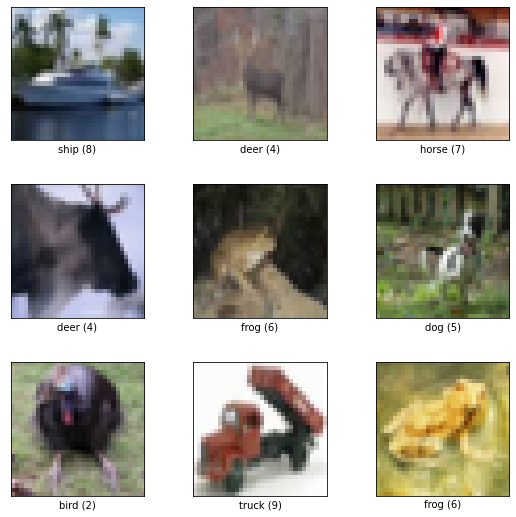

In [10]:
#샘플
fig = tfds.show_examples(ds_train, ds_info)

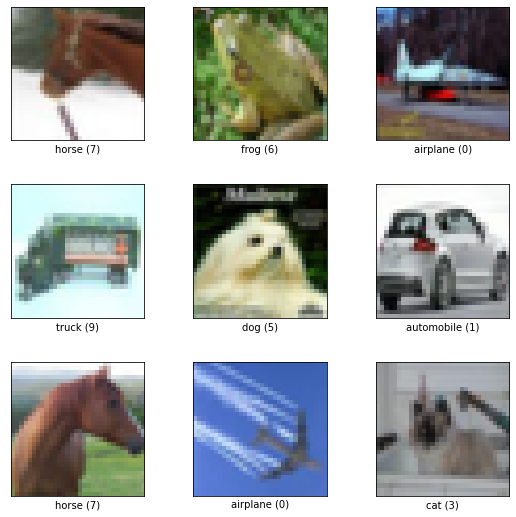

In [11]:
fig = tfds.show_examples(ds_test, ds_info)

## vgg 예지, blockFn, 모델Fn 만들기

In [12]:
# block 만드는 함수 
# vgg 유사

In [13]:
# function for building VGG Block
# num_cnn 필터*커널) 사이즈 가로세로.


def build_vgg_block(input_layer,
                    num_cnn=3,  #
                    channel=64,
                    block_num=1,
                   ):
    # 입력 레이어
    x = input_layer

    # CNN 레이어
    for cnn_num in range(num_cnn):
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(3,3),
            activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_conv{cnn_num}'
        )(x)    

    # Max Pooling 레이어
    x = keras.layers.MaxPooling2D(
        pool_size=(2, 2),
        strides=2,
        name=f'block{block_num}_pooling'
    )(x)

    return x

In [14]:
# 함수 실행.

In [15]:
vgg_input_layer = keras.layers.Input(shape=(32,32,3))   # 입력 레이어 생성
vgg_block_output = build_vgg_block(vgg_input_layer)    # VGG 블록 생성

In [16]:
# 블록 1개짜리 model 생성
model = keras.Model(inputs=vgg_input_layer, outputs=vgg_block_output)  

model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv0 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pooling (MaxPooling2D (None, 16, 16, 64)        0         
Total params: 75,648
Trainable params: 75,648
Non-trainable params: 0
_________________________________________________________________


### vgg-16 make

In [17]:
# VGG 모델 자체를 생성하는 함수입니다.
def build_vgg(input_shape=(32,32,3),
              num_cnn_list=[2,2,3,3,3],
              channel_list=[64,128,256,512,512],
              num_classes=10):
    
    assert len(num_cnn_list) == len(channel_list) #모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    
    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    output = input_layer
    print(output.shape)
    # config list들의 길이만큼 반복해서 블록을 생성합니다.
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output = build_vgg_block(
            output,
            num_cnn=num_cnn, 
            channel=channel,
            block_num=i
        )
        
    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(4096, activation='relu', name='fc1')(output)
    output = keras.layers.Dense(4096, activation='relu', name='fc2')(output)
    output = keras.layers.Dense(num_classes, activation='softmax', name='predictions')(output)
    print(output.shape)
    model = keras.Model(
        inputs=input_layer, 
        outputs=output
    )
    return model

In [18]:
# 기본값을 그대로 사용해서 VGG 모델을 만들면 VGG-16이 됩니다.
vgg_16 = build_vgg()

vgg_16.summary()

(None, 32, 32, 3)
(None, 10)
Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block0_conv0 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block0_conv1 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block0_pooling (MaxPooling2D (None, 16, 16, 64)        0         
_________________________________________________________________
block1_conv0 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block1_pooling (MaxPoolin

### vgg-19

In [19]:
# 원하는 블록의 설계에 따라 매개변수로 리스트를 전달해 줍니다.
vgg_19 = build_vgg(
    num_cnn_list=[2,2,4,4,4],
    channel_list=[64,128,256,512,512]
)

vgg_19.summary()

(None, 32, 32, 3)
(None, 10)
Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block0_conv0 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block0_conv1 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block0_pooling (MaxPooling2D (None, 16, 16, 64)        0         
_________________________________________________________________
block1_conv0 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block1_pooling (MaxPoolin

## 성능비교
- vgg 16 vs 19

In [20]:
BATCH_SIZE = 256
EPOCH = 20

In [21]:
# data set load

In [22]:
(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

In [23]:
# vgg 16 훈련
vgg_16.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_16 = vgg_16.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
  2/195 [..............................] - ETA: 1:02 - loss: 2.3067 - accuracy: 0.1074WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.1473s vs `on_train_batch_end` time: 0.5004s). Check your callbacks.


195/195 [==============================] - 124s 635ms/step - loss: 2.1877 - accuracy: 0.1854 - val_loss: 2.0948 - val_accuracy: 0.2293
Epoch 2/20
195/195 [==============================] - 110s 563ms/step - loss: 2.0315 - accuracy: 0.2601 - val_loss: 1.9721 - val_accuracy: 0.2926
Epoch 3/20
195/195 [==============================] - 116s 597ms/step - loss: 1.9054 - accuracy: 0.3141 - val_loss: 1.8731 - val_accuracy: 0.3078
Epoch 4/20
195/195 [==============================] - 108s 552ms/step - loss: 1.7966 - accuracy: 0.3556 - val_loss: 1.7603 - val_accuracy: 0.3828
Epoch 5/20
195/195 [==============================] - 90s 461ms/step - loss: 1.7089 - accuracy: 0.3879 - val_loss: 1.6425 - val_accuracy: 0.4102
Epoch 6/20
195/195 [==============================] - 80s 409ms/step - loss: 1.6357 - accuracy: 0.4136 - val_loss: 1.6198 - val_accuracy: 0.4195
Epoch 7/20
195/195 [==============================] - 81s 415ms/step - loss: 1.5705 - accuracy: 0.4355 - val_loss: 1.5512 - val_accuracy:

KeyboardInterrupt: 

In [ ]:
#vgg 19 훈련
vgg_19.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_19 = vgg_19.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)


In [ ]:
# 비교 그래프

import matplotlib.pyplot as plt

plt.plot(history_16.history['loss'], 'r')
plt.plot(history_19.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['vgg_16', 'vgg_19'], loc='upper left')
plt.show()

In [ ]:
# 검증 정확도

plt.plot(history_16.history['val_accuracy'], 'r')
plt.plot(history_19.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['vgg_16', 'vgg_19'], loc='upper left')
plt.show()


## Project. resnet ablation


In [ ]:
![](./imgs/

### resnet 생성 함수

In [ ]:
# function for building VGG Block
# num_cnn 필터*커널) 사이즈 가로세로.


def build_resnet_block(input_layer,
                    num_cnn=2, 
                    channel=64,
                    block_num=1,
                    is_50 = True,# False: 34(3x3), True, 50: 1x1, 3x3, 1x1
                    plain = False # False: residual model ,True: plain model, 
                   ):
    # 입력 레이어
    x = input_layer
    print("4-", block_num)
    print("4", x.shape)

    
    identity_value = input_layer # <residual 위한.
    
    for n in range(num_cnn): 
        if not is_50 : #34 layer 이면...
            for cnn_num in range(2): # num cnn 2
                x = keras.layers.Conv2D(
                    filters=channel, # 64, 128,256,512
                    kernel_size=(3,3),
                    activation='relu', ## ...
                    kernel_initializer='he_normal', ## ...
                    padding='same', ## ...
                    name=f'block{block_num}_conv{cnn_num}' ## ...
                 )(x)
                print("aa")


        else : # 50 layer
            cnn_num = 0

            # 1x1 첫번째...
            x = keras.layers.Conv2D(
                    filters=channel, # 64, 128,256,512
                    kernel_size=(1,1),
                    activation='relu', ## ...
                    kernel_initializer='he_normal', ## ...
                    padding='same', ## ...
                    name=f'block{block_num}_conv{cnn_num}' ## ...
            )(x)
            cnn_num=cnn_num+1

            ## 3ㅌ3 두번째 
            x = keras.layers.Conv2D(
                    filters=channel, # 64, 128,256,512
                    kernel_size=(3,3),
                    activation='relu', ## ...
                    kernel_initializer='he_normal', ## ...
                    padding='same', ## ...
                    name=f'block{block_num}_conv{cnn_num}' ## ...
            )(x)

            # 1x1 첫번째..
            cnn_num=cnn_num+1
            x = keras.layers.Conv2D(
                filters=channel*4, # 요기만 4배 크기의 채널 사이즈.....
                kernel_size=(1,1),
                activation='relu', ## ...
                kernel_initializer='he_normal', ## ...
                padding='same', ## ...
                name=f'block{block_num}_conv{cnn_num}' ## ...
            )(x)
    print("5-", block_num)           
    print("5", x.shape)
    
    x = keras.layers.Add(name=f'shortcut_add_{block_num}')([x, identity_value])
    x = keras.layers.Activation('relu', name=f'shortcut_act_{block_num}')(x)

   

    return x

In [ ]:
  ### 역[ 한블럭 shotcut 생성, 1x1, 3x3, 1x1 
### 바뀌는 것 반복횟수, 필터 수 
    
    x = MaxPooling2D((3, 3), 2)(x)     
 
    shortcut = x
 
    for i in range(3):
        if (i == 0):
            x = Conv2D(64, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(x)
            shortcut = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(shortcut)            
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)
 
            x = Add()([x, shortcut])
            x = Activation('relu')(x)
            
            shortcut = x
 
        else:
            x = Conv2D(64, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)            
 
            x = Add()([x, shortcut])   
            x = Activation('relu')(x)  
 
            shortcut = x        
    
    return x

In [ ]:

# RESNET 생성함수.
def build_resnet(input_shape=(32,32,3),
              num_cnn_list=[3,4,6,3], # 3 4 6 3공통
              channel_list=[64,128,256,512], # 공통, 50은 각 블럭 마지막 만 x4
              num_classes=10,
               is_50=False,
                ):
    
    assert len(num_cnn_list) == len(channel_list) #모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    
    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    output = input_layer
    block_num = 0
    
    #######################################################
    ## 공통 영역, 7x conv 3x maxpooling
    print("1", output.shape)
     # 7xu conv 64, stribe 2
    output = keras.layers.Conv2D(
            filters=64, 
            kernel_size=(7,7),
            strides=2,
            kernel_initializer='he_normal',
            kernel_regularizer=keras.regularizers.l2(1e-4),
            padding='same',
            name=f'block{block_num}_conv{0}' ## ...
    )(output)   
    block_num = block_num +1
    # 왜................................................ㅅㅂ
    

    print("2", output.shape)

    
    # 3x3 max pool, stribe 2
    #Max Pooling 레이어
    output = keras.layers.MaxPooling2D(
        pool_size=(2, 2),
        strides=2,
        name=f'block{block_num}_pooling'
    )(output)
    

    print("3", output.shape)

    #######################################################
    
    # config list들의 길이만큼 반복해서 블록을 생성합니다.
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output = build_resnet_block(
            output,
            num_cnn=num_cnn, 
            channel=channel,
            block_num=i+1,
            is_50 = is_50
        )
        
    #######################################################
    
    # average pool
    
        
#     output = keras.layers.Flatten(name='flatten')(output)
#     output = keras.layers.Dense(4096, activation='relu', name='fc1')(output)
#     output = keras.layers.Dense(4096, activation='relu', name='fc2')(output)
#     output = keras.layers.Dense(num_classes, activation='softmax', name='predictions')(output)

    
    model = keras.Model(
        inputs=input_layer, 
        outputs=output
    )
    return model

### resnet_34,50 구성

In [25]:
from keras import models, layers
from keras import Input
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers, initializers, regularizers, metrics
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import BatchNormalization, Conv2D, Activation, Dense, GlobalAveragePooling2D, MaxPooling2D, ZeroPadding2D, Add
 
import os
import matplotlib.pyplot as plt
import numpy as np
import math
 
 
 
# number of classes
K = 4
 
 
input_tensor = Input(shape=(224, 224, 3), dtype='float32', name='input')
 
 
def conv1_layer(x):    
    x = ZeroPadding2D(padding=(3, 3))(x)
    x = Conv2D(64, (7, 7), strides=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = ZeroPadding2D(padding=(1,1))(x)
 
    return x   
 
    
 
def conv2_layer(x):         
    x = MaxPooling2D((3, 3), 2)(x)     
 
    shortcut = x
 
    for i in range(3):
        if (i == 0):
            x = Conv2D(64, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(x)
            shortcut = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(shortcut)            
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)
 
            x = Add()([x, shortcut])
            x = Activation('relu')(x)
            
            shortcut = x
 
        else:
            x = Conv2D(64, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)            
 
            x = Add()([x, shortcut])   
            x = Activation('relu')(x)  
 
            shortcut = x        
    
    return x
 
 
 
def conv3_layer(x):        
    shortcut = x    
    
    for i in range(4):     
        if(i == 0):            
            x = Conv2D(128, (1, 1), strides=(2, 2), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)        
            
            x = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)  
 
            x = Conv2D(512, (1, 1), strides=(1, 1), padding='valid')(x)
            shortcut = Conv2D(512, (1, 1), strides=(2, 2), padding='valid')(shortcut)
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)            
 
            x = Add()([x, shortcut])    
            x = Activation('relu')(x)    
 
            shortcut = x              
        
        else:
            x = Conv2D(128, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(512, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)            
 
            x = Add()([x, shortcut])     
            x = Activation('relu')(x)
 
            shortcut = x      
            
    return x
 
 
 
def conv4_layer(x):
    shortcut = x        
  
    for i in range(6):     
        if(i == 0):            
            x = Conv2D(256, (1, 1), strides=(2, 2), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)        
            
            x = Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)  
 
            x = Conv2D(1024, (1, 1), strides=(1, 1), padding='valid')(x)
            shortcut = Conv2D(1024, (1, 1), strides=(2, 2), padding='valid')(shortcut)
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)
 
            x = Add()([x, shortcut]) 
            x = Activation('relu')(x)
 
            shortcut = x               
        
        else:
            x = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(1024, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)            
 
            x = Add()([x, shortcut])    
            x = Activation('relu')(x)
 
            shortcut = x      
 
    return x
 
 
 
def conv5_layer(x):
    shortcut = x    
  
    for i in range(3):     
        if(i == 0):            
            x = Conv2D(512, (1, 1), strides=(2, 2), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)        
            
            x = Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)  
 
            x = Conv2D(2048, (1, 1), strides=(1, 1), padding='valid')(x)
            shortcut = Conv2D(2048, (1, 1), strides=(2, 2), padding='valid')(shortcut)
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)            
 
            x = Add()([x, shortcut])  
            x = Activation('relu')(x)      
 
            shortcut = x               
        
        else:
            x = Conv2D(512, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(2048, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)           
            
            x = Add()([x, shortcut]) 
            x = Activation('relu')(x)       
 
            shortcut = x                  
 
    return x
 
 
 
x = conv1_layer(input_tensor)
x = conv2_layer(x)
x = conv3_layer(x)
x = conv4_layer(x)
x = conv5_layer(x)
 
x = GlobalAveragePooling2D()(x)
output_tensor = Dense(K, activation='softmax')(x)
 
resnet50 = Model(input_tensor, output_tensor)
resnet50.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input[0][0]                      
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 64) 9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 112, 112, 64) 256         conv2d[0][0]                     
_______________________________________________________________________________________

In [ ]:

resnet_34 = build_resnet(input_shape=(224, 224,3), is_50=False)
resnet_34.summary()

In [32]:
##  50 구성

resnet_50.summary()

#왤까.................ㅠ

NameError: name 'resnet_50' is not defined

### reset 34,50 훈련

In [28]:
BATCH_SIZE = 256
EPOCH = 10

In [29]:
(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

In [ ]:
##
# resnet 34  훈련
resnet_34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_resnet_34 = resnet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

In [31]:
##
# resnet50
resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_resnet_50 = resnet50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10


195/195 [==============================] - ETA: 0s - loss: nan - accuracy: 0.1017WARNING:tensorflow:Model was constructed with shape (None, 224, 224, 3) for input Tensor("input:0", shape=(None, 224, 224, 3), dtype=float32), but it was called on an input with incompatible shape (None, 32, 32, 3).


195/195 [==============================] - 135s 691ms/step - loss: nan - accuracy: 0.1017 - val_loss: nan - val_accuracy: 0.0980
Epoch 2/10
195/195 [==============================] - 108s 555ms/step - loss: nan - accuracy: 0.0990 - val_loss: nan - val_accuracy: 0.1031
Epoch 3/10
195/195 [==============================] - 65s 335ms/step - loss: nan - accuracy: 0.1007 - val_loss: nan - val_accuracy: 0.1004
Epoch 4/10
195/195 [==============================] - 80s 412ms/step - loss: nan - accuracy: 0.1004 - val_loss: nan - val_accuracy: 0.1054
Epoch 5/10
195/195 [==============================] - 106s 546ms/step - loss: nan - accuracy: 0.1001 - val_loss: nan - val_accuracy: 0.1004
Epoch 6/10
195/195 [==============================] - 97s 497ms/step - loss: nan - accuracy: 0.0989 - val_loss: nan - val_accuracy: 0.0980
Epoch 7/10
195/195 [==============================] - 19s 96ms/step - loss: nan - accuracy: 0.0996 - val_loss: nan - val_accuracy: 0.0982
Epoch 8/10
195/195 [================

### renet 34, 50 성능비교

In [ ]:
# 비교 그래프

import matplotlib.pyplot as plt

plt.plot(history_resnet_34.history['loss'], 'r')
plt.plot(history_resnet_50.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'resnet_50'], loc='upper left')
plt.show()

In [ ]:
# 검증 정확도

plt.plot(history_resnet_34.history['val_accuracy'], 'r')
plt.plot(history_resnet_50.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'resnet_50'], loc='upper left')
plt.show()


### cats_vs_dogs 데이터셋